### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
## Read Data for Cases, Deaths and Recoveries
confirmed_cases_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_raw = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')


In [4]:
confirmed_cases_raw.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,773,782,789,795,803,820,832,842,850,856
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,745,745,747,748,750,751,751,752,752,754
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,27,30,35,35,35,36,36,36,43,43


In [5]:
### Melt the dateframe into the right shape and set index
def melt_data(df_raw, drop_country=None):
    df_cleaned = df_raw.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], value_name='Cases',
                             var_name='Date')
    df_cleaned = df_cleaned.set_index(['Country/Region', 'Province/State', 'Date'])
    if drop_country:
        df_cleaned.drop(drop_country, level=0, inplace=True)
    return df_cleaned


### Get Country-wise Data
def country_wise(df_cleaned, oldname, newname):
    df_country = df_cleaned.groupby(['Country/Region', 'Date'])['Cases'].sum().reset_index()
    df_country = df_country.set_index(['Country/Region', 'Date'])
    df_country.index = df_country.index.set_levels(
        [df_country.index.levels[0], pd.to_datetime(df_country.index.levels[1])])
    df_country = df_country.sort_values(['Country/Region', 'Date'], ascending=True)
    df_country = df_country.rename(columns={oldname: newname})
    return df_country


### Get DailyData from Cumulative sum
def dailydata(dfcountry, oldname, newname):
    dfcountrydaily = dfcountry.groupby(level=0).diff().fillna(0)
    dfcountrydaily = dfcountrydaily.rename(columns={oldname: newname})
    return dfcountrydaily

In [6]:
# Clean all datasets
confirmed_cases = melt_data(confirmed_cases_raw, ['China', 'Mainland China'])
deaths = melt_data(deaths_raw, ['China', 'Mainland China'])
recoveries = melt_data(recoveries_raw, ['China', 'Mainland China'])

In [7]:
confirmed_cases.head()

,,,Lat,Long,Cases
Country/Region,Province/State,Date,,,
Afghanistan,NaN,1/22/20,33.0000,65.0000,0
Albania,NaN,1/22/20,41.1533,20.1683,0
Algeria,NaN,1/22/20,28.0339,1.6596,0
Andorra,NaN,1/22/20,42.5063,1.5218,0
Angola,NaN,1/22/20,-11.2027,17.8739,0


In [8]:
# Get country-wise data
confirmed_cases_country = country_wise(confirmed_cases, 'Cases', 'Total Confirmed Cases')
deaths_country = country_wise(deaths, 'Cases', 'Total Deaths')
recoveries_country = country_wise(recoveries, 'Cases', 'Total Recoveries')

In [9]:
# Get Daily Data
new_cases_country = dailydata(confirmed_cases_country, 'Total Confirmed Cases', 'Daily New Cases')
new_deaths_country = dailydata(deaths_country, 'Total Deaths', 'Daily New Deaths')
new_recoveries_country = dailydata(recoveries_country, 'Total Recoveries', 'Daily New Recoveries')

In [10]:
covid_cases = pd.merge(confirmed_cases_country, new_cases_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, deaths_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, recoveries_country, how='left', left_index=True, right_index=True)
covid_cases = pd.merge(covid_cases, new_recoveries_country, how='left', left_index=True, right_index=True)


covid_cases['Active Cases'] = covid_cases['Total Confirmed Cases'] - covid_cases[
    'Total Deaths'] - covid_cases['Total Recoveries']
covid_cases['Share of Recoveries - Closed Cases'] = np.round(covid_cases['Total Recoveries'] / (
        covid_cases['Total Recoveries'] + covid_cases['Total Deaths']), 2)
covid_cases['Death to Cases Ratio'] = np.round(
    covid_cases['Total Deaths'] / covid_cases['Total Confirmed Cases'], 3)


In [11]:
global_totals = covid_cases.reset_index().groupby('Date').sum()
global_totals['Share of Recoveries - Closed Cases'] = np.round(
    global_totals['Total Recoveries'] / (global_totals['Total Recoveries'] + global_totals['Total Deaths']), 2)
global_totals['Death to Cases Ratio'] = np.round(global_totals['Total Deaths'] / global_totals['Total Confirmed Cases'], 3)
global_totals.tail(2)

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-05-08,3854088,92345.0,5331.0,270261,1243057,37293.0,2340770,0.82,0.07
2020-05-09,3940019,85931.0,4413.0,274674,1296497,53440.0,2368848,0.83,0.07


# Plot Global Total Cases

In [12]:
global_totals.iloc[-1]

Total Confirmed Cases                 3940019.00
Daily New Cases                         85931.00
Daily New Deaths                         4413.00
Total Deaths                           274674.00
Total Recoveries                      1296497.00
Daily New Recoveries                    53440.00
Active Cases                          2368848.00
Share of Recoveries - Closed Cases          0.83
Death to Cases Ratio                        0.07
Name: 2020-05-09 00:00:00, dtype: float64

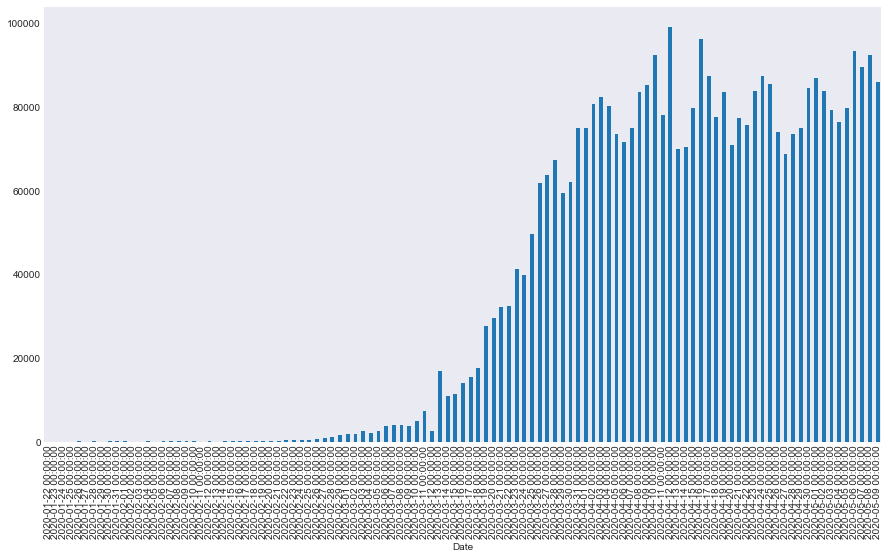

In [13]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['Daily New Cases'].plot.bar()

In [14]:
#plt.plot(GlobalTotals['Daily New Cases'])
global_totals['growth'] = global_totals['Daily New Cases'] / global_totals['Active Cases']

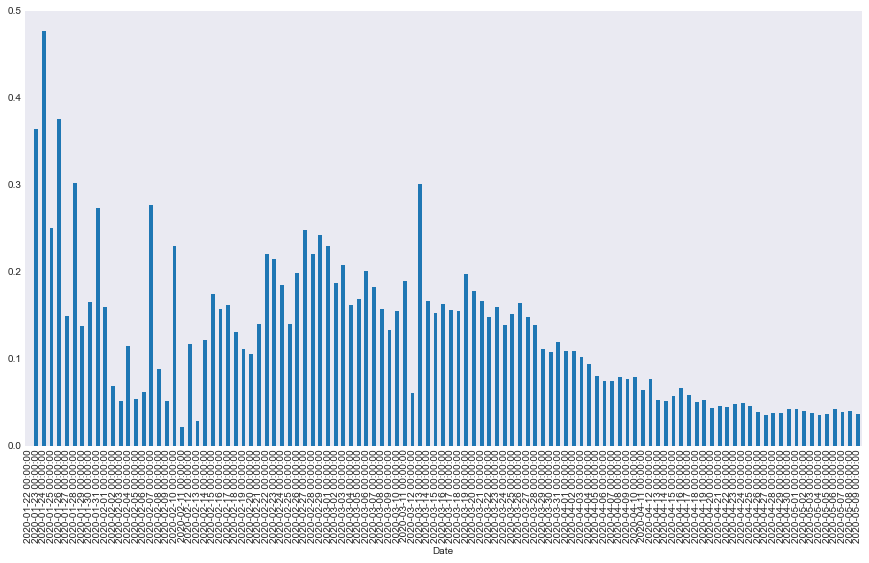

In [15]:
global_totals['growth'].plot.bar()

# Explore Country Specific Data

In [16]:
germany = covid_cases.loc['Germany'].copy()
germany.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-05-05,167007,855.0,0.0,6993,135100,2400.0,24914,0.95,0.042
2020-05-06,168162,1155.0,282.0,7275,139900,4800.0,20987,0.95,0.043
2020-05-07,169430,1268.0,117.0,7392,141700,1800.0,20338,0.95,0.044
2020-05-08,170588,1158.0,118.0,7510,141700,0.0,21378,0.95,0.044
2020-05-09,171324,736.0,39.0,7549,143300,1600.0,20475,0.95,0.044


In [17]:
south_korea = covid_cases.loc['Korea, South'].copy()
south_korea.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-05-05,10806,2.0,1.0,255,9333,50.0,1218,0.97,0.024
2020-05-06,10810,4.0,1.0,256,9419,86.0,1135,0.97,0.024
2020-05-07,10822,12.0,0.0,256,9484,65.0,1082,0.97,0.024
2020-05-08,10840,18.0,0.0,256,9568,84.0,1016,0.97,0.024
2020-05-09,10874,34.0,0.0,256,9610,42.0,1008,0.97,0.024


In [18]:
belgium = covid_cases.loc['Belgium'].copy()
belgium.tail()

,Total Confirmed Cases,Daily New Cases,Daily New Deaths,Total Deaths,Total Recoveries,Daily New Recoveries,Active Cases,Share of Recoveries - Closed Cases,Death to Cases Ratio
Date,,,,,,,,,
2020-05-05,50509,242.0,92.0,8016,12441,63.0,30052,0.61,0.159
2020-05-06,50781,272.0,323.0,8339,12731,290.0,29711,0.60,0.164
2020-05-07,51420,639.0,76.0,8415,12980,249.0,30025,0.61,0.164
2020-05-08,52011,591.0,106.0,8521,13201,221.0,30289,0.61,0.164
2020-05-09,52596,585.0,60.0,8581,13411,210.0,30604,0.61,0.163


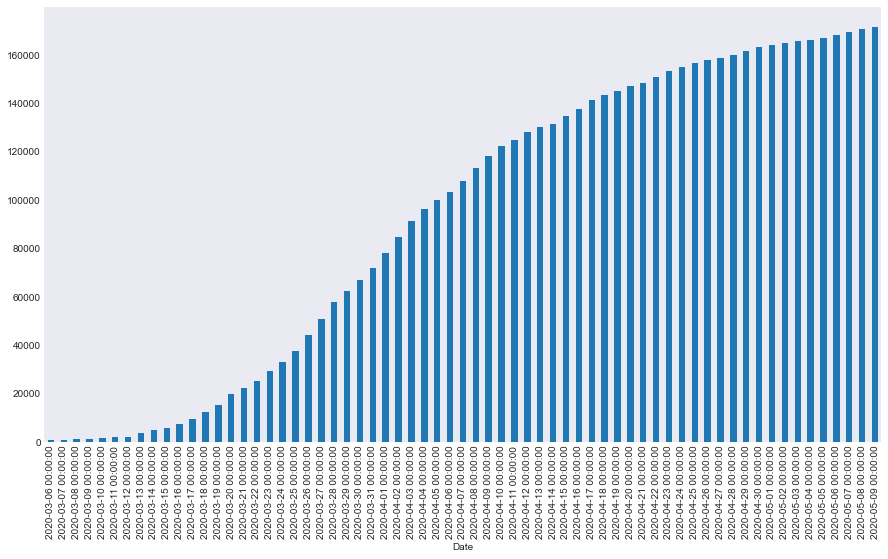

In [19]:
germany['Total Confirmed Cases'].loc['03-06-2020':].plot.bar()

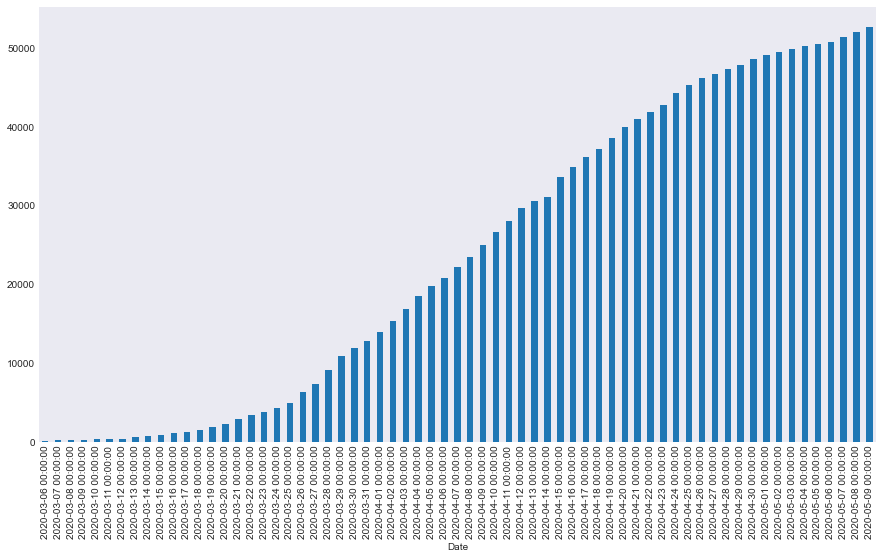

In [20]:
belgium['Total Confirmed Cases'].loc['03-06-2020':].plot.bar()

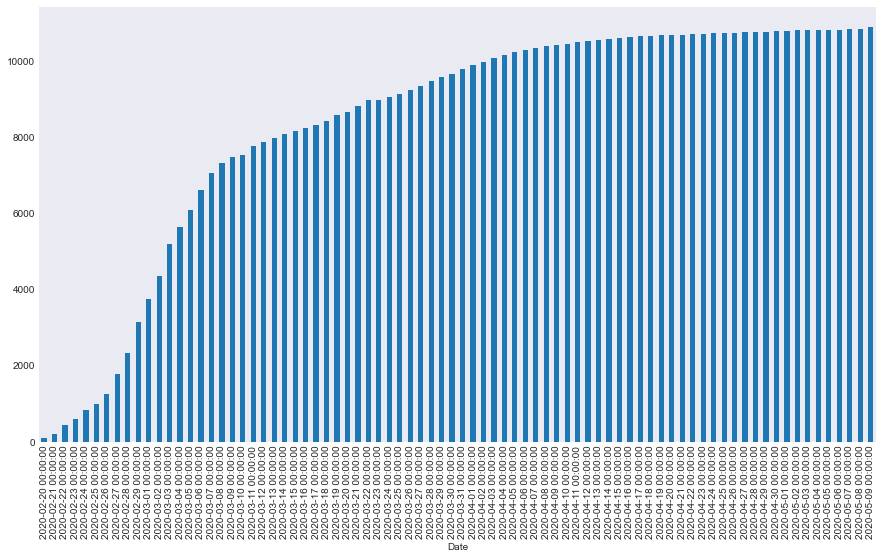

In [21]:
south_korea['Total Confirmed Cases'].loc['02-20-2020':].plot.bar()

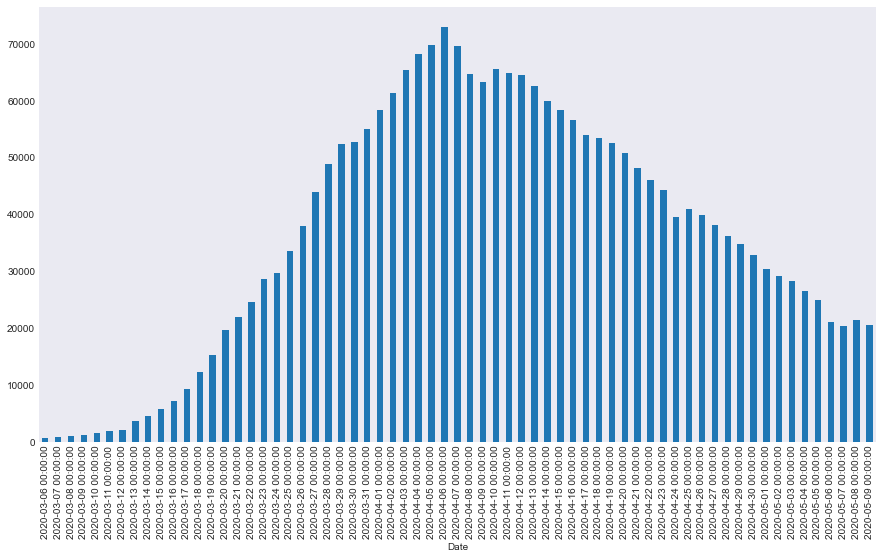

In [22]:
germany['Active Cases'].loc['03-06-2020':].plot.bar()

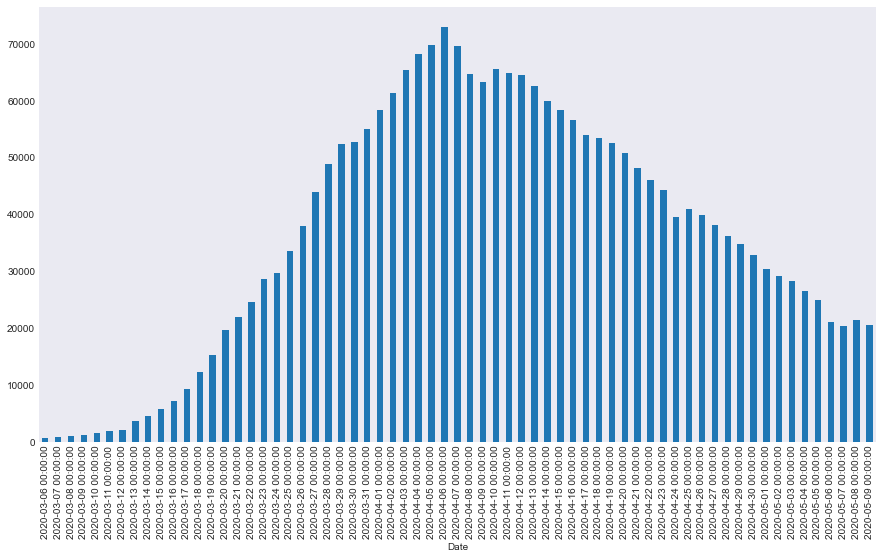

In [23]:
germany['Active Cases'].loc['03-06-2020':].plot.bar()

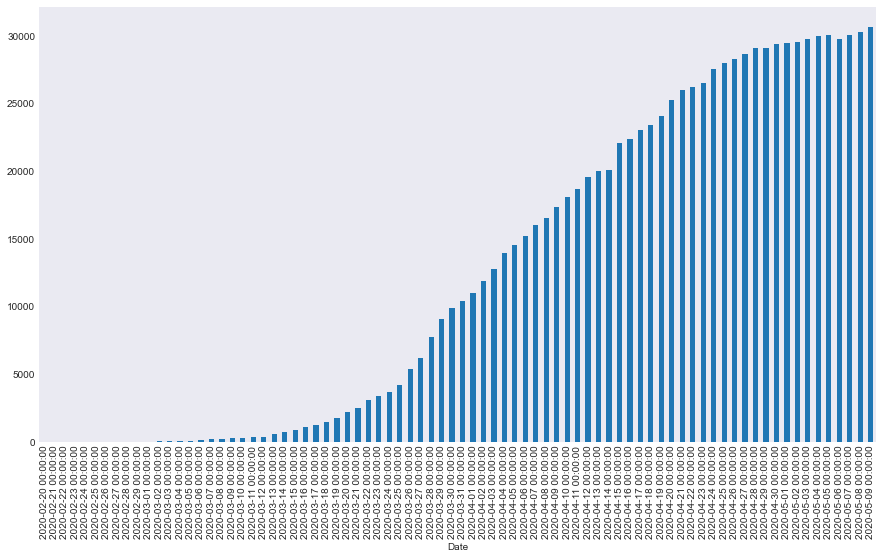

In [24]:
belgium['Active Cases'].loc['02-20-2020':].plot.bar()

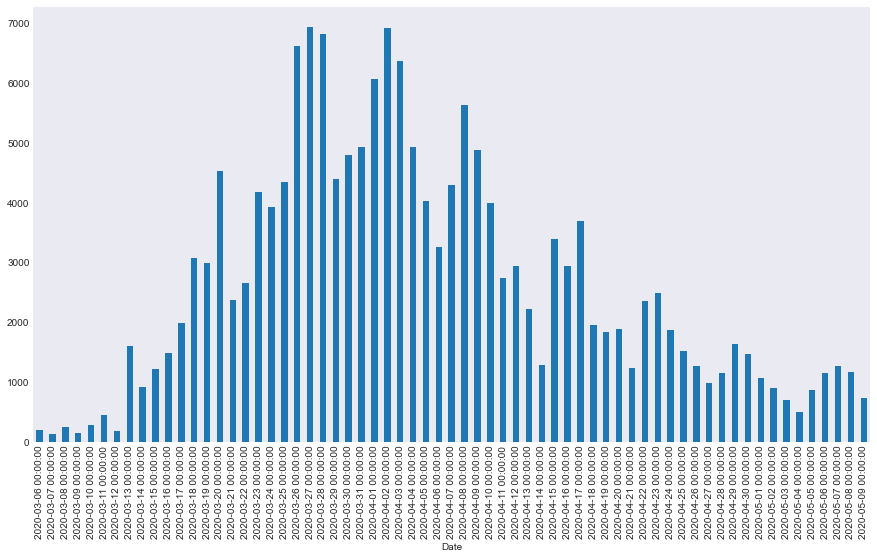

In [25]:
germany['Daily New Cases'].loc['03-06-2020':].plot.bar()

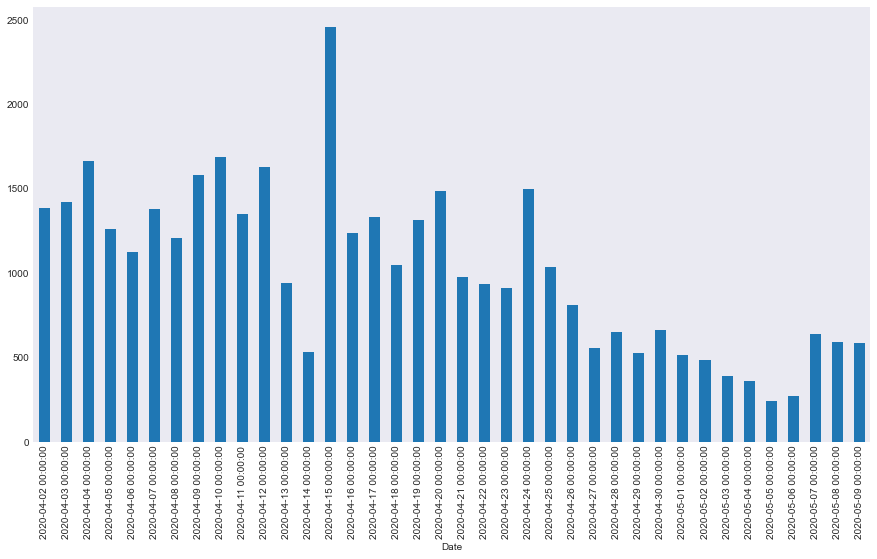

In [26]:
belgium['Daily New Cases'].iloc[-38:].plot.bar()

In [27]:
germany['growth rate'] = germany['Daily New Cases'] / germany['Active Cases']

In [28]:
start_date = '02-25-2020'
past_window = len(germany) - germany['growth rate'].index.get_loc(start_date)
past_window

75

In [29]:
#past_window = 45

In [30]:
germany_growth_moving_average = germany['growth rate'].iloc[-past_window:].rolling(window=3).mean()
germany_growth_ema = germany['growth rate'].iloc[-past_window:].ewm(span=6,adjust=False).mean()

Text(0.5, 1.0, 'Growth = Daily New Cases / Active Cases')

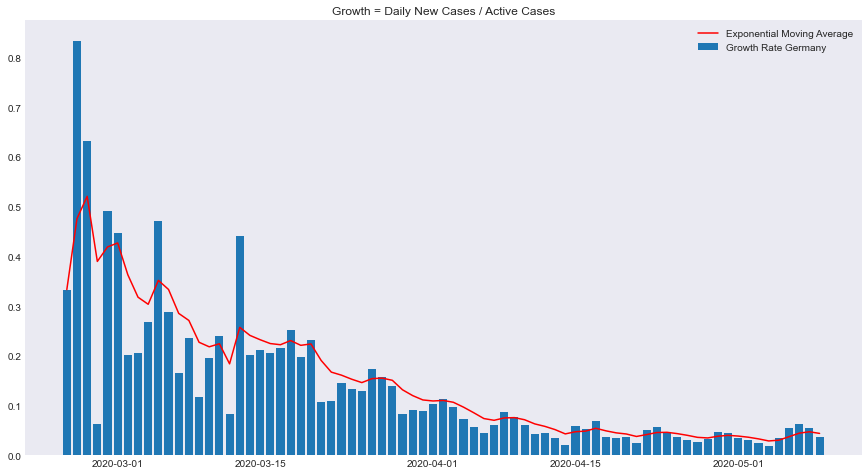

In [31]:
plt.bar(germany.iloc[-past_window:].index, germany['growth rate'].iloc[-past_window:], label='Growth Rate Germany')
#plt.plot(germany_growth_moving_average.index, germany_growth_moving_average, label='Moving Average', color='red')
plt.plot(germany_growth_ema.index, germany_growth_ema, label='Exponential Moving Average', color='red')

plt.legend(loc='best')
plt.title('Growth = Daily New Cases / Active Cases')

In [32]:
germany['growth rate'].tail(10)

Date
2020-04-30    0.044700
2020-05-01    0.035084
2020-05-02    0.030526
2020-05-03    0.024718
2020-05-04    0.018444
2020-05-05    0.034318
2020-05-06    0.055034
2020-05-07    0.062346
2020-05-08    0.054168
2020-05-09    0.035946
Name: growth rate, dtype: float64

In [33]:
south_korea['growth rate'] = south_korea['Daily New Cases'] / south_korea['Active Cases']

In [34]:
belgium['growth rate'] = belgium['Daily New Cases'] / belgium['Active Cases']

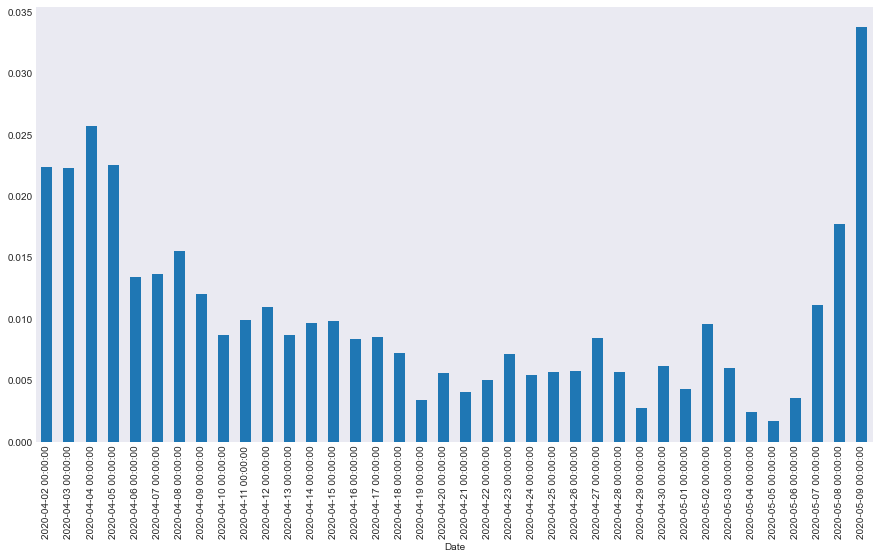

In [35]:
south_korea['growth rate'].iloc[-38:].plot.bar()

Text(0.5, 1.0, 'Growth Belgium')

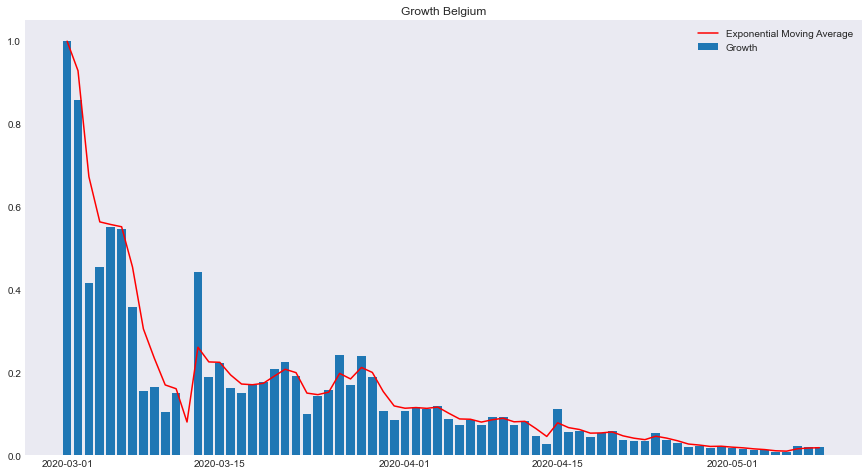

In [36]:
start_date = '03-01-2020'
x = belgium[start_date:].index

plt.bar(x, belgium['growth rate'][start_date:], label='Growth')
plt.plot(x, belgium['growth rate'].ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Belgium')

Text(0.5, 1.0, 'Growth Germany')

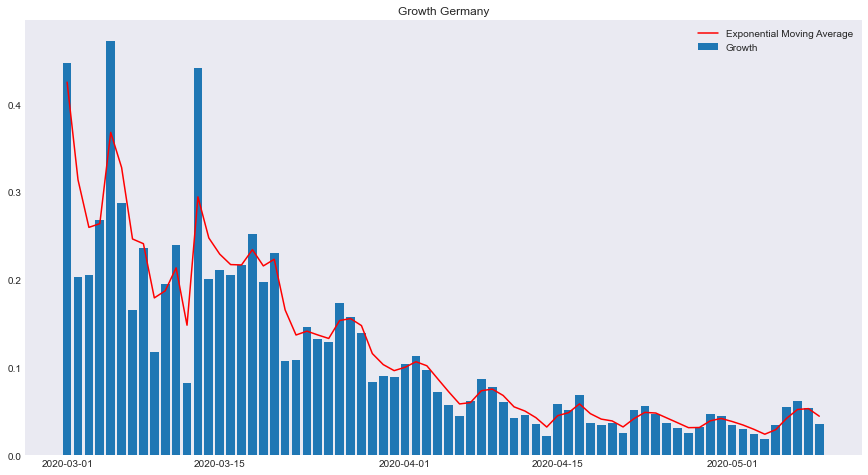

In [37]:
start_date = '03-01-2020'
x = germany[start_date:].index

plt.bar(x, germany['growth rate'][start_date:], label='Growth')
plt.plot(x, germany['growth rate'].ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

In [38]:
south_korea['growth rate'].tail(10)

Date
2020-04-30    0.006190
2020-05-01    0.004264
2020-05-02    0.009559
2020-05-03    0.006006
2020-05-04    0.002368
2020-05-05    0.001642
2020-05-06    0.003524
2020-05-07    0.011091
2020-05-08    0.017717
2020-05-09    0.033730
Name: growth rate, dtype: float64

In [39]:
germany['growth rate'].tail(10)

Date
2020-04-30    0.044700
2020-05-01    0.035084
2020-05-02    0.030526
2020-05-03    0.024718
2020-05-04    0.018444
2020-05-05    0.034318
2020-05-06    0.055034
2020-05-07    0.062346
2020-05-08    0.054168
2020-05-09    0.035946
Name: growth rate, dtype: float64

In [40]:
belgium['growth rate'].tail(10)

Date
2020-04-30    0.022488
2020-05-01    0.017427
2020-05-02    0.016418
2020-05-03    0.013074
2020-05-04    0.012047
2020-05-05    0.008053
2020-05-06    0.009155
2020-05-07    0.021282
2020-05-08    0.019512
2020-05-09    0.019115
Name: growth rate, dtype: float64